
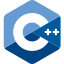
<br>

<div style="text-align:center; font-size:200%;">
 <b>Isolation von Unit-Tests</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 08 Isolation von Unit-Tests.ipynb -->
<!-- slides/module_410_unit_testing/topic_160_test_isolation.cpp -->


## Unit-Test

- Testet einen kleinen Teil des Codes (eine **"Unit"**)
- Hat kurze Laufzeit
- *Ist isoliert*


## Was ist eine "Unit"?

- Ein Verhalten?
  - *Unit of behavior*
  - Teil eines Szenarios/Use-Cases/...
  - Ursprüngliche Intention von Kent Beck
- Ein Code-Bestandteil?
  - *Unit of code*
  - Oft Unit = Klasse
  - In der Literatur weit verbreitete Ansicht


## Was bedeutet "isolierter" Test?

- Keine Interaktion zwischen Tests?
  - Isolierte Testfälle
  - Klassische Unit-Tests (Detroit School, Kent Beck)
- Keine Interaktion zwischen getesteter Einheit und dem Rest des Systems?
  - Abhängigkeiten werden durch einfache Simulationen ersetzt (Test-Doubles)
  - London School


## Isolierte Testfälle (Detroit School)

- Jeder Testfall ist unabhängig von den anderen
- Tests können in beliebiger Reihenfolge ausgeführt werden
- Tests können parallel ausgeführt werden


### Gegenbeispiel: Nicht isolierte Testfälle

In [ ]:
#include <iostream>

In [ ]:
void check(bool condition)
{
    if (!condition)
    {
        std::cerr << "Test failed!\n";
    }
}

In [ ]:
#include <chrono>
#include <ctime>
#include <iomanip>
#include <iostream>
#include <thread>

In [ ]:
void print_time(std::string prefix, std::chrono::system_clock::time_point time_point)
{
    std::time_t time = std::chrono::system_clock::to_time_t(time_point);
    std::tm* localTime = std::localtime(&time);
    std::cout << prefix << std::put_time(localTime, "%Y-%m-%d %H:%M:%S") << '\n';
}


## Gründe für nicht isolierte Testfälle

- Veränderlicher globaler Zustand
- Veränderliche externe Ressourcen (Dateien, Datenbanken, Netzwerk, ...)


## Isolation der getesteten Unit

- Die getestete Unit wird von allen anderen Units isoliert
- Test-Doubles für alle Abhängigkeiten


### Gegenbeispiel: Nicht isolierte Unit

- Verkäufer von Veranstaltungs-Tickets
- Konkrete Klasse `Event` repräsentiert eine Veranstaltung

In [ ]:
#include <iostream>
#include <stdexcept>
#include <string>

In [ ]:
namespace non_isolated
{
class Event
{
private:
    std::string name{"Unnamed Event"};
    int capacity{};

public:
    Event() = default;
    Event(std::string name, int capacity) : name{name}, capacity{capacity} {}

    std::string get_name() const { return name; }
    int get_capacity() const { return capacity; }
    void purchase(int num_tickets);
};
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
void Event::purchase(int num_tickets)
{
    if (num_tickets > capacity)
    {
        throw std::runtime_error("Not enough capacity");
    }
    capacity -= num_tickets;
}
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
class TicketOffice
{
private:
    std::unordered_map<std::string, Event> events;

public:
    void add_event(Event event) { events[event.get_name()] = event; }
    Event get_event(std::string event_name) { return events[event_name]; }
    bool purchase_tickets(std::string event_name, int num_tickets);
};
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
bool TicketOffice::purchase_tickets(std::string event_name, int num_tickets)
{
    if (events.find(event_name) != events.end())
    {
        try
        {
            events[event_name].purchase(num_tickets);
            return true;
        }
        catch (const std::runtime_error& e)
        {
            std::cerr << "Cannot purchase " << num_tickets << " tickets for "
                      << event_name << '\n';
            std::cerr << e.what() << '\n';
            return false;
        }
    }
    return false;
}
} // namespace non_isolated

In [ ]:
namespace non_isolated
{
void test_purchase_tickets()
{
    TicketOffice ticket_office;
    Event event("CppCon", 100);
    ticket_office.add_event(event);

    bool result = ticket_office.purchase_tickets("CppCon", 10);

    check(result == true);
    check(ticket_office.get_event("CppCon").get_capacity() == 90);
}
} // namespace non_isolated

In [ ]:
namespace isolated
{
class Event
{
public:
    Event() = default;
    Event(const Event&) = delete;
    Event& operator=(const Event&) = delete;
    Event(Event&&) = delete;
    Event& operator=(Event&&) = delete;
    virtual ~Event() = default;

    virtual std::string get_name() const = 0;
    virtual int get_capacity() const = 0;
    virtual void purchase(int num_tickets) = 0;
};
} // namespace isolated

In [ ]:
namespace isolated
{
class ConcreteEvent : public Event
{
private:
    std::string name{"Unnamed Event"};
    int capacity{};

public:
    ConcreteEvent() = default;
    ConcreteEvent(std::string name, int capacity) : name{name}, capacity{capacity} {}

    std::string get_name() const override { return name; }
    int get_capacity() const override { return capacity; }
    void purchase(int num_tickets) override;
};
} // namespace isolated

In [ ]:
namespace isolated
{
void ConcreteEvent::purchase(int num_tickets)
{
    if (num_tickets > capacity)
    {
        throw std::runtime_error("Not enough capacity");
    }
    capacity -= num_tickets;
}
} // namespace isolated

In [ ]:
namespace isolated
{
class TicketOffice
{
private:
    std::unordered_map<std::string, std::unique_ptr<Event>> events;

public:
    void add_event(std::unique_ptr<Event> event)
    {
        events[event->get_name()] = std::move(event);
    }
    Event& get_event(std::string event_name) { return *events.at(event_name); }
    bool purchase_tickets(std::string event_name, int num_tickets);
};
} // namespace isolated

In [ ]:
namespace isolated
{
bool TicketOffice::purchase_tickets(std::string event_name, int num_tickets)
{
    if (events.find(event_name) != events.end())
    {
        try
        {
            events.at(event_name)->purchase(num_tickets);
            return true;
        }
        catch (const std::out_of_range& e)
        {
            std::cerr << event_name << " not found\n";
            std::cerr << e.what() << '\n';
            return false;
        }
        catch (const std::runtime_error& e)
        {
            std::cerr << "Cannot purchase " << num_tickets << " tickets for "
                      << event_name << '\n';
            std::cerr << e.what() << '\n';
            return false;
        }
    }
    return false;
}
} // namespace isolated


### Isolation von `TicketOffice` für Tests

- Entkopplung von allen Abhängigkeiten
- `EventMock`-Implementierung für Events

In [ ]:
namespace isolated
{
class EventMock : public Event
{
public:
    std::vector<int> purchase_args{};

    std::string get_name() const override { return "CppCon"; }
    int get_capacity() const override { return 90; }
    void purchase(int num_tickets) override { purchase_args.push_back(num_tickets); }
};
} // namespace isolated

In [ ]:
namespace isolated
{
void test_purchase_tickets()
{
    TicketOffice ticket_office;
    ticket_office.add_event(std::make_unique<EventMock>());

    bool result{ticket_office.purchase_tickets("CppCon", 10)};

    check(result == true);
    check(ticket_office.get_event("CppCon").get_capacity() == 90);
    check(
        static_cast<EventMock&>(ticket_office.get_event("CppCon")).purchase_args ==
        std::vector<int>{10}
    );
}
} // namespace isolated


## Vorteile der Isolation der getesteten Unit

- Einfache Struktur der Tests
  - Jeder Test gehört zu genau einer Unit
- Genaue Identifikation von Fehlern
- Aufbrechen von Abhängigkeiten/des Objektgraphen


## Nachteile der Isolation der getesteten Unit

- Potenziell höherer Aufwand (z.B. Mocks)
- Fehler in der Interaktion zwischen Units werden nicht gefunden
- Verleiten zum Schreiben von "Interaktionstests"
- **Risiko von Kopplung an Implementierungsdetails**


## Empfehlung

- Verwenden Sie isolierte Unit-Tests (Detroit School)
- Isolieren Sie Abhängigkeiten, die "eine Rakete starten"
  - nicht-deterministisch (z.B. Zufallszahlen, aktuelle Zeit, aktuelles Datum)
  - langsam
  - externe Systeme (z.B. Datenbank)
- Isolieren Sie Abhängigkeiten, die ein komplexes Setup benötigen


## Workshop: Virtuelle Universität

- Im `code`-Ordner finden Sie eine Implementierung eins sehr einfachen
  Verwaltungssystems für eine Universität:
- Es gibt Kurse, Professoren, die die Kurse halten, Studenten, die Aufgaben
  bearbeiten und abgeben müssen.
- Der Code ist in `code/starter_kits/virtual_university` zu finden.
- Die `main.cpp`-Datei illustriert, wie die Klassen zusammenarbeiten und
  verwendet werden können.


- Identifizieren Sie, welche Klassen und Methoden zu den "wertvollsten"
  Unit-Tests führen.
- Implementieren Sie diese Unit-Tests mit Catch2.
  - Idealerweise implementieren sie Tests für alle Klassen, die sinnvolle
    Tests haben.
  - Falls Sie dafür nicht genug Zeit haben, können Sie auch nur Tests für
    einen Teil des Codes schreiben.
  - Die Klasse `Student` ist ein ganz guter Startpunkt, weil sie eine sehr
    begrenzte Funktionalität hat, die Sie mit relativ wenigen Tests abdecken
    können.


- Überlegen Sie, wie Sie das System überarbeiten müssten, um die Klassen in
  Tests vollständig zu isolieren, also im London School Stil zu testen.
  - (Sie müssen das nicht tatsächlich umsetzen, weil es recht aufwändig ist,
    aber es ist eine gute Übung, um die beiden Stile zu vergleichen.)